# Dessazonalização com STL

Neste notebook, aplicamos a decomposição STL para remover a sazonalidade das séries temporais de **óbitos** e **internações** por causas cardiovasculares.

O objetivo principal é evidenciar as **tendências reais** dessas séries, facilitando a comparação entre os períodos pré e pós-pandemia de COVID-19.

In [1]:
import pandas as pd

# Adiciona o diretório de scripts ao path para importar funções
from scripts.carregamento import carregar_dados_tratados
from scripts.dessazonalizacao import dessazonalizar_em_lote, plot_dessazonalizacao, dessazonalizar

## Carregamento dos Dados Tratados

Nesta etapa, carregamos os dados previamente tratados e organizados por categoria:

- Mortalidade (óbitos)
- Morbidade (internações)

Esses dados estão prontos para a aplicação da dessazonalização com STL.


In [2]:
# Carrega todos os dados tratados organizados por categoria
dados = carregar_dados_tratados("../dados_tratados")

## Aplicação da Dessazonalização STL

Utilizamos o algoritmo **STL (Seasonal and Trend decomposition using Loess)** para cada evento cardiovascular.

As séries dessazonalizadas resultantes são salvas nos diretórios:

- `graficos/dessazonalizadas_mortalidade/`
- `graficos/dessazonalizadas_morbidade/`

Esses arquivos serão utilizados em análises visuais e quantitativas posteriores.

In [3]:
# Define os eventos que possuem sazonalidade
eventos_com_sazonalidade = [
    "obitos_avc",
    "obitos_infarto",
    "obitos_arritmias",
    "obitos_insuf_cardiaca",
    "internacoes_arritmias_cardiacas",
    "internacoes_avc",
    "internacoes_infarto",
    "internacoes_trombose",

]

In [4]:
# Dessazonaliza os dados de mortalidade
dados_dessaz_mortalidade = dessazonalizar_em_lote(
    dicionario_eventos=dados["mortalidade"],
    eventos_a_dessazonalizar=eventos_com_sazonalidade
)

In [5]:
# Dessazonaliza os dados de morbidade
dados_dessaz_morbidade = dessazonalizar_em_lote(
    dicionario_eventos=dados["morbidade"],
    eventos_a_dessazonalizar=eventos_com_sazonalidade
)

## Análise Visual das Séries Dessazonalizadas

A seguir, são apresentados os gráficos das séries dessazonalizadas para os seguintes eventos:

- Óbitos: AVC, Infarto, Insuficiência Cardíaca, Miocardite, Trombose
- Internações: Arritmias, AVC, Infarto, Trombose

Essas visualizações auxiliam na identificação de:

- Mudanças de tendência ao longo do tempo;
- Padrões atípicos que não estavam visíveis nas séries originais com sazonalidade.


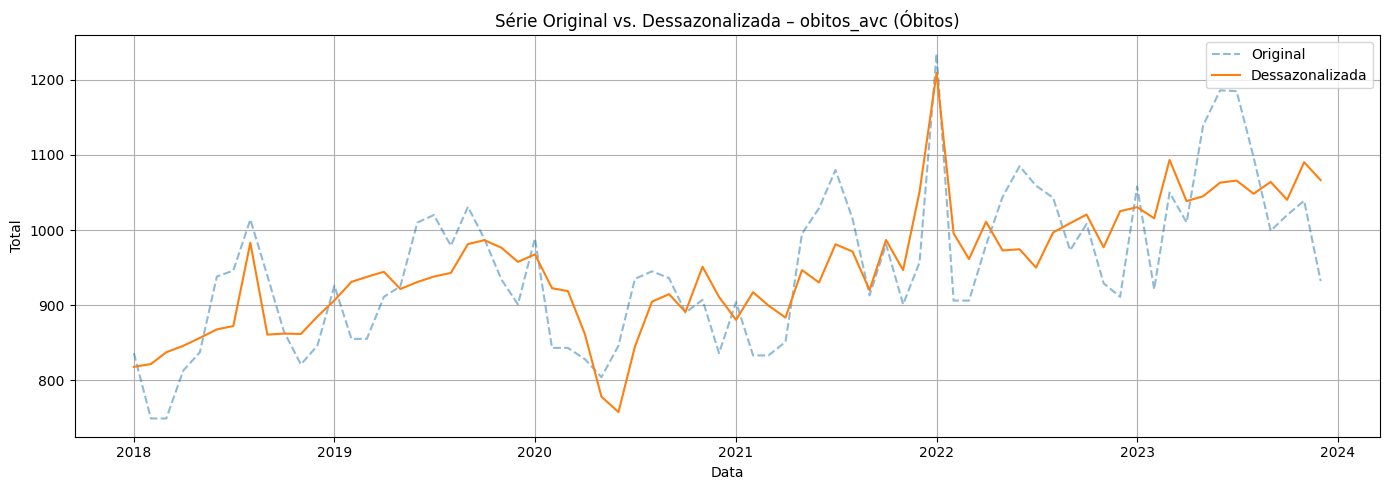

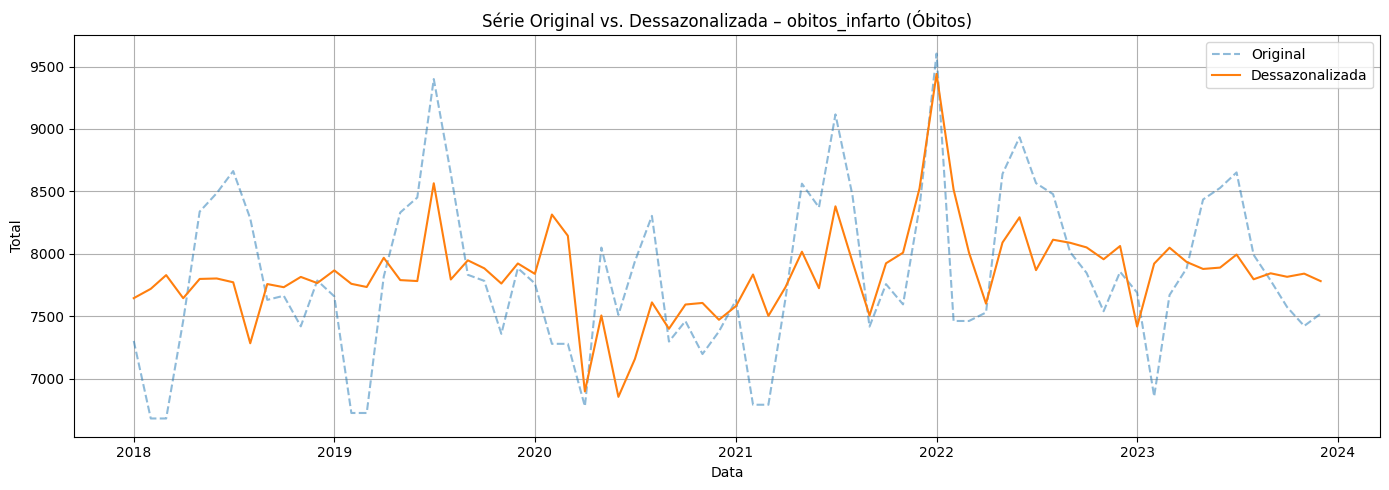

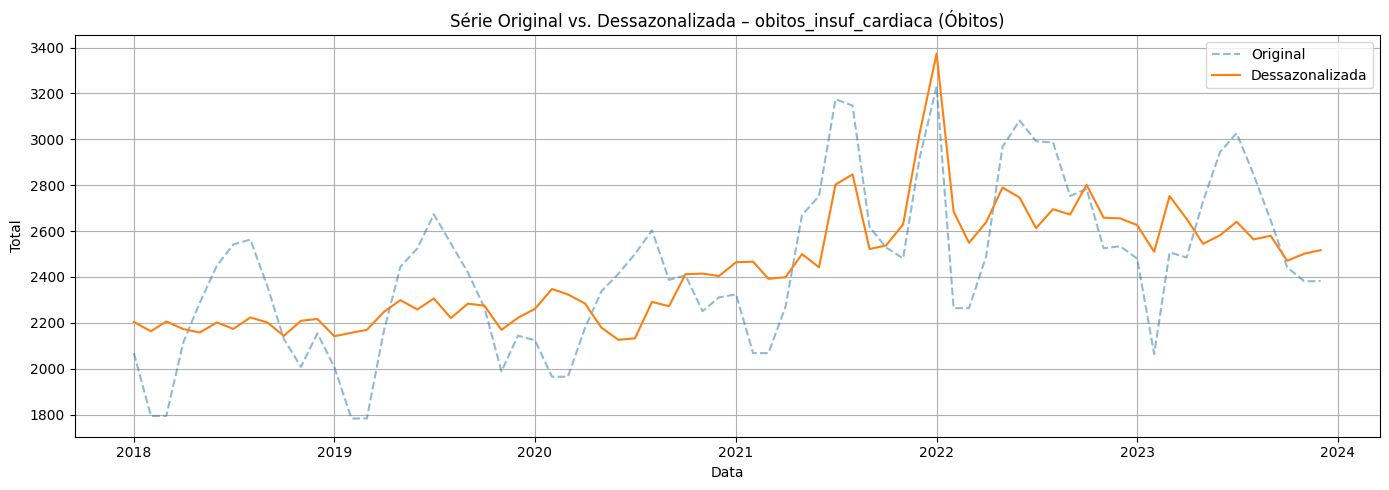

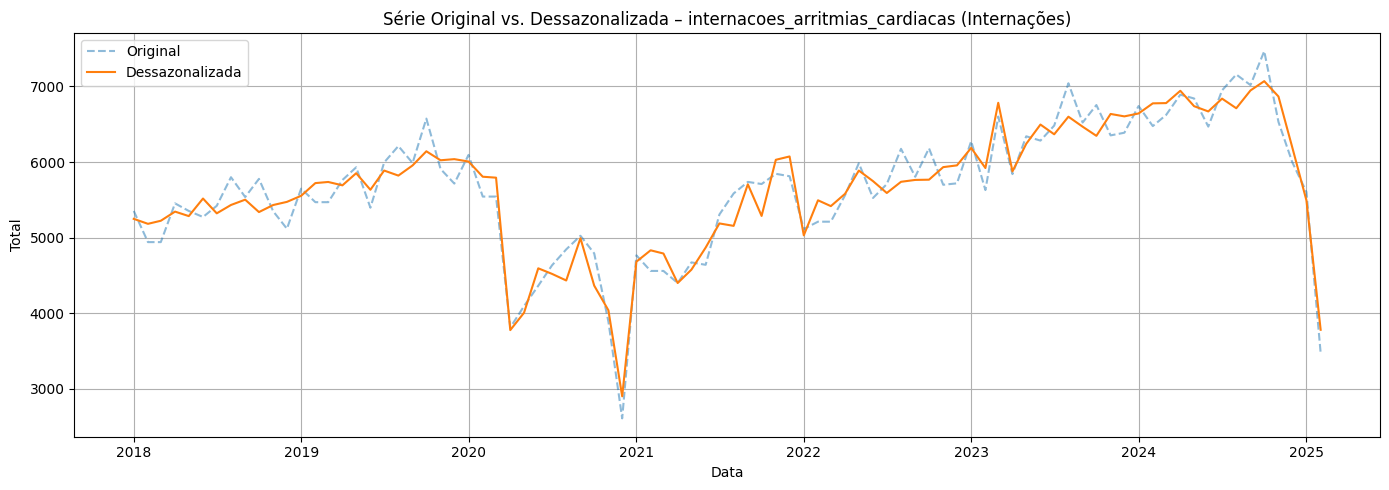

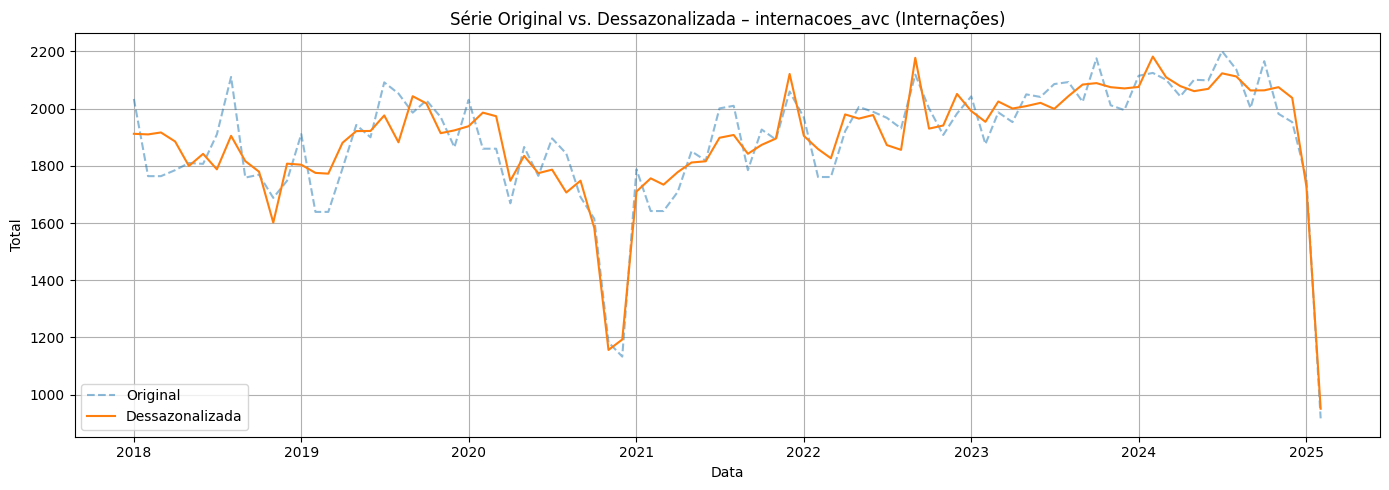

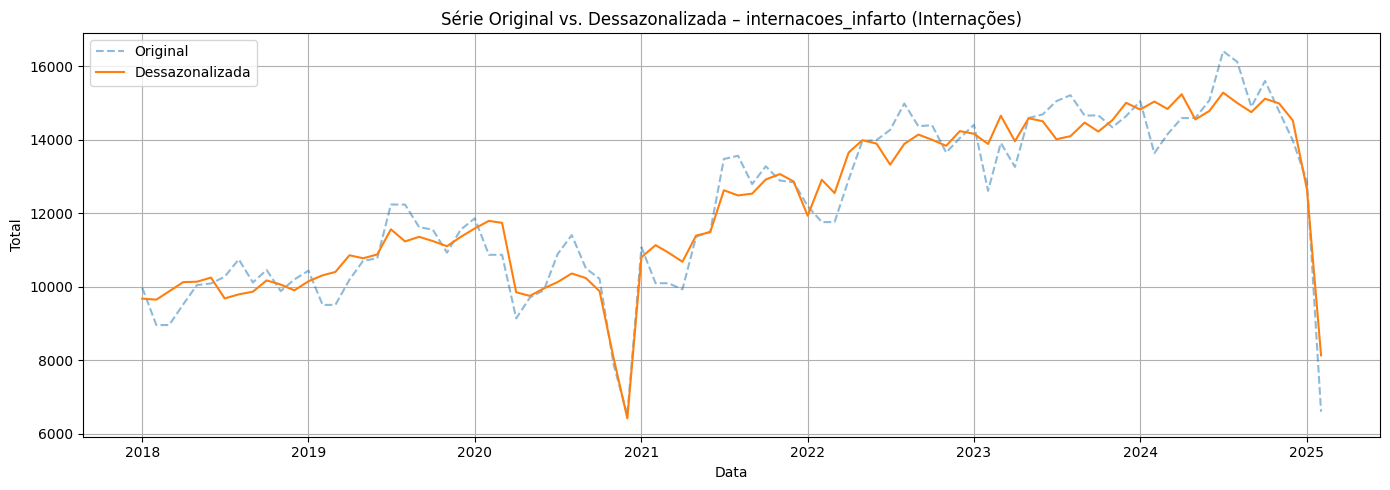

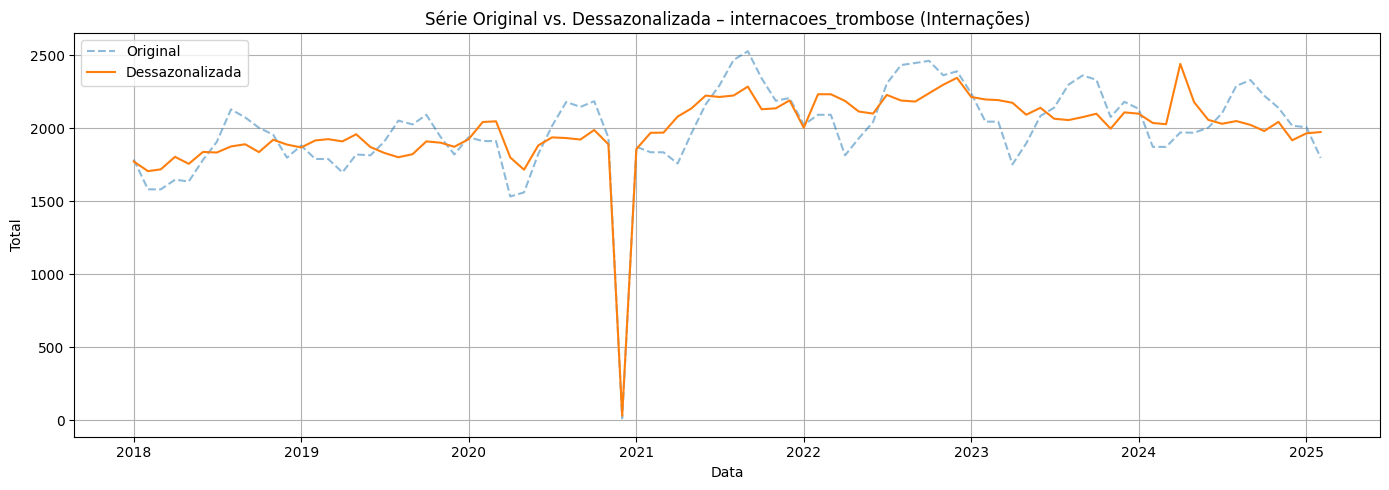

In [6]:
# Plotar Gráficos Dessazonalizados de Mortalidade
eventos_mort = [ev for ev in eventos_com_sazonalidade if ev in dados_dessaz_mortalidade]
for evento in eventos_mort:
    df = dados_dessaz_mortalidade[evento]
    plot_dessazonalizacao(
        df,
        coluna="Total",
        titulo=f"{evento} (Óbitos)",
        salvar_em="../graficos/dessazonalizadas_mortalidade"
    )

# Plotar Gráficos Dessazonalizados de Morbidade
eventos_morb = [ev for ev in eventos_com_sazonalidade if ev in dados_dessaz_morbidade]
for evento in eventos_morb:
    df = dados_dessaz_morbidade[evento]
    plot_dessazonalizacao(
        df,
        coluna="Total",
        titulo=f"{evento} (Internações)",
        salvar_em="../graficos/dessazonalizadas_morbidade"
    )

## Análise de Variabilidade: Coeficiente de Variação (CV)

Nesta etapa, repetimos o cálculo do **coeficiente de variação (CV)** — agora utilizando as **séries temporais já dessazonalizadas** com o método STL.

Embora o CV tenha sido explorado anteriormente, esta nova aplicação permite uma avaliação mais precisa da **instabilidade relativa** das séries, isolando o efeito da sazonalidade.

A comparação entre os períodos **pré-pandemia** e **durante/pós-pandemia** revela mudanças na dispersão mensal das séries, agora sem a influência de padrões sazonais regulares.


In [7]:
def calcular_cv_periodos(df, coluna="dessazonalizado", corte="2020-01-01"):
    """
    Calcula o CV antes e depois da data de corte.
    """
    import pandas as pd

    # Cópia e conversão de data para índice datetime
    df = df.copy()
    if "data" in df.columns:
        df["data"] = pd.to_datetime(df["data"])
        df = df.set_index("data")
    # Garante que corte é datetime
    corte = pd.to_datetime(corte)

    df_antes  = df[df.index < corte]
    df_depois = df[df.index >= corte]

    cv_antes  = df_antes[coluna].std()  / df_antes[coluna].mean()  if not df_antes.empty  else None
    cv_depois = df_depois[coluna].std() / df_depois[coluna].mean() if not df_depois.empty else None

    return cv_antes, cv_depois

# Mortalidade
resultados_cv_mortalidade = []
for evento, df in dados_dessaz_mortalidade.items():
    if "dessazonalizado" in df.columns:
        cv_antes, cv_depois = calcular_cv_periodos(df)
        resultados_cv_mortalidade.append({
            "evento": evento,
            "cv_antes": cv_antes,
            "cv_depois": cv_depois
        })
df_cv_mortalidade = pd.DataFrame(resultados_cv_mortalidade)
display(df_cv_mortalidade)

# Morbidade
resultados_cv_morbidade = []
for evento, df in dados_dessaz_morbidade.items():
    if "dessazonalizado" in df.columns:
        cv_antes, cv_depois = calcular_cv_periodos(df)
        resultados_cv_morbidade.append({
            "evento": evento,
            "cv_antes": cv_antes,
            "cv_depois": cv_depois
        })
df_cv_morbidade = pd.DataFrame(resultados_cv_morbidade)
display(df_cv_morbidade)

,evento,cv_antes,cv_depois
0,obitos_avc,0.059540,0.085833
1,obitos_infarto,0.026718,0.053373
2,obitos_insuf_cardiaca,0.021958,0.088857


,evento,cv_antes,cv_depois
0,internacoes_arritmias_cardiacas,0.050923,0.168760
1,internacoes_avc,0.050321,0.119852
2,internacoes_infarto,0.059318,0.159774
3,internacoes_trombose,0.035773,0.143348


## Interpretação dos Resultados de CV Pós-Dessazonalização

### Principais observações:

- **Aumento da variabilidade nas internações**: após a pandemia, muitas séries de internações apresentaram triplicação no CV, indicando alta instabilidade.
  
- **Óbitos mais estáveis**: embora tenha ocorrido aumento no CV, a intensidade foi menor do que nas internações, sugerindo estabilidade relativa nos registros de mortalidade.

### Conclusões:

1. **Impacto na regularidade do sistema de saúde**: as internações tornaram-se mais irregulares e imprevisíveis, possivelmente por sobrecarga ou reorganização dos serviços.
2. **Óbitos menos afetados**: o registro de óbitos manteve maior consistência, o que pode indicar que as internações foram mais vulneráveis a barreiras operacionais.
3. **CV como métrica de instabilidade**: a elevação do CV reforça a existência de maior oscilação nas séries, mesmo após remoção da sazonalidade.

**Resumo:** além de pressionado, o sistema de saúde tornou-se mais errático e instável no contexto da pandemia.
